<a href="https://colab.research.google.com/github/Zzl85199/Apple_stock_predict/blob/main/Stock_Forecasting_using_LSTM_and_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge


from numpy.random import seed
seed(69)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Kaggle/AAPL.csv.xls", parse_dates=['Date'])
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098578,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103376,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107739,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113409,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.123877,55574400


In [ ]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['Open Price Change'] = data['Open'].diff()

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,Open Price Change
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600,1980,12,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800,1980,12,-0.006138
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000,1980,12,-0.008929
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600,1980,12,0.002232
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600,1980,12,0.003349


Text(0.5, 1.0, 'Volume trend over time')

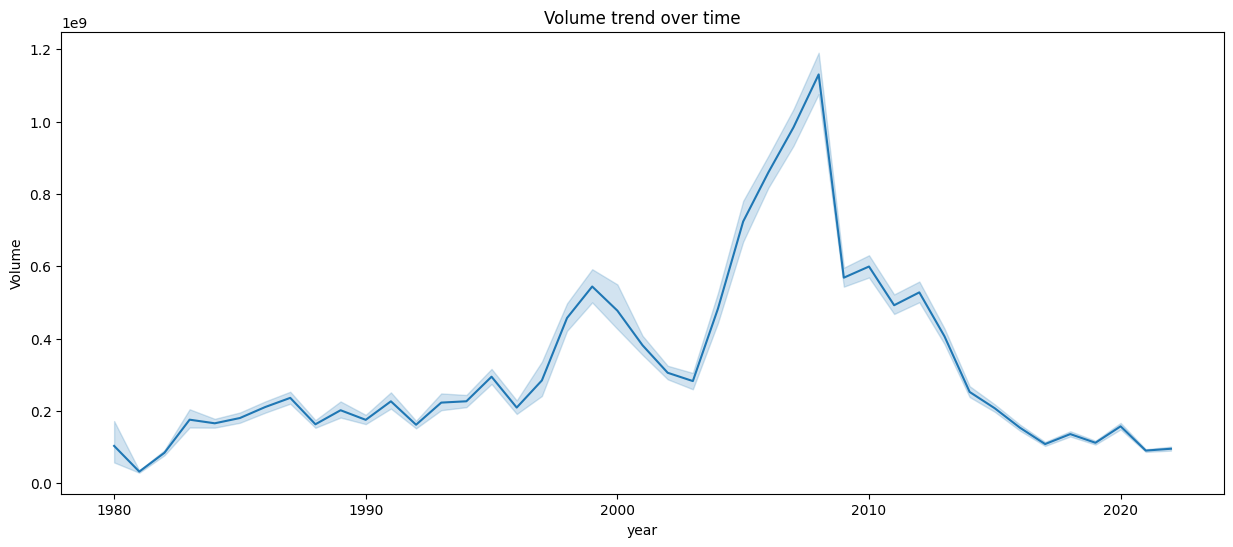

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(y = data['Volume'], x= data['year'])
plt.title("Volume trend over time")

Text(0.5, 1.0, 'Adj Close trend over time')

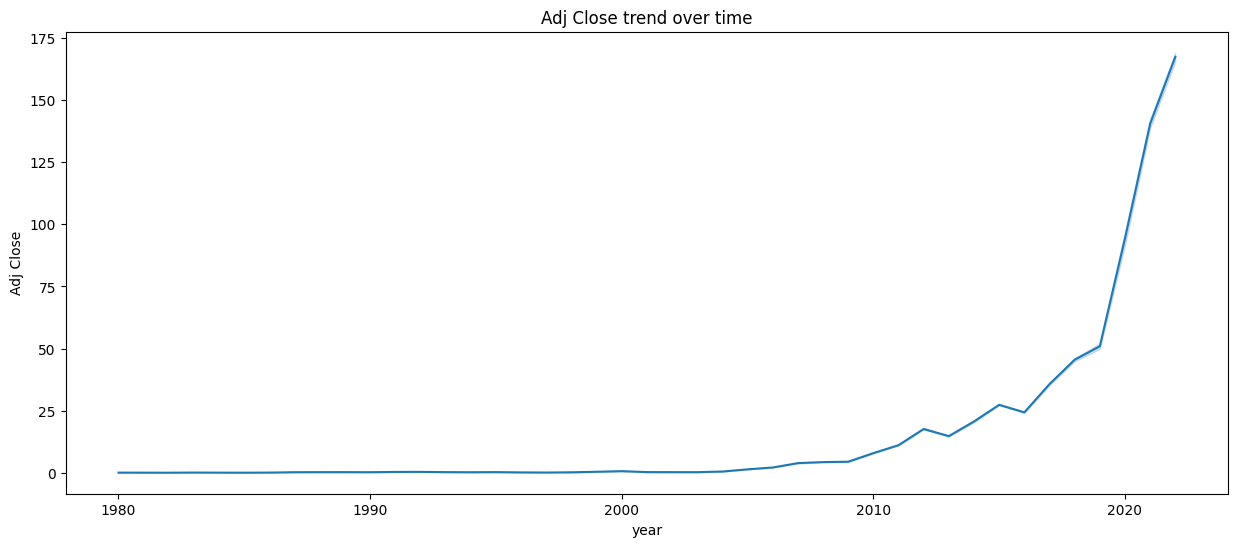

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(y = data['Adj Close'], x= data['year'])
plt.title("Adj Close trend over time")

In [ ]:
open_price = go.Waterfall(x = data['Date'], y = data['Open Price Change'],
                         decreasing = {'marker': {'color': 'red'}},
                          increasing = {'marker': {'color': 'green'}})

layout = go.Layout(title = 'Apple Open Price Change Waterfall',
                  xaxis = dict(title = 'Date'), yaxis = dict(title = 'Open Price Change'),
                  xaxis_tickangle = 45)

fig = go.Figure(data = [open_price], layout = layout)
fig.show()

In [ ]:
#準備訓練資料
df_apple = pd.read_csv("/content/drive/My Drive/Kaggle/AAPL.csv.xls")
df_apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [ ]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'], format="%Y-%m-%d")

In [ ]:
open_price=df_apple.loc[:,'Open'].to_numpy()

In [ ]:
open_price = open_price.reshape(-1, 1)  # 將 open_price 數組重新整形為一列
train_set = open_price[:7000]       # 選取前 7000 筆數據作為訓練集
valid_set = open_price[7000:8000]     # 選取 7000 到 8000 筆數據作為驗證集
test_set = open_price[8000:]        # 選取 8000 筆數據之後的所有數據作為測試集

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))     # 創建訓練集的歸一化處理器
sc_valid = MinMaxScaler(feature_range=(0, 1))  # 創建驗證集的歸一化處理器
sc_test = MinMaxScaler(feature_range=(0, 1))   # 創建測試集的歸一化處理器

train_set_scaled = sc.fit_transform(train_set)     # 對訓練集進行歸一化處理
valid_set_scaled = sc_valid.fit_transform(valid_set)  # 對驗證集進行歸一化處理
test_set_scaled = sc_test.fit_transform(test_set)    # 對測試集進行歸一化處理

#  數據在 0 到 1 的範圍內正確地縮放，從而有助於避免因數據範圍差異太大而導致的學習效率問題。

In [ ]:
def generate_data(data, window_size_input=300):
    X = []
    y = []
    for i in range(window_size_input, len(data)):
        X_data = data[i - window_size_input:i, 0]  # 提取從當前索引向前推 window_size_input 的數據作為特徵
        y_data = data[i, 0]              # 提取當前索引的數據作為預測目標
        X.append(X_data)
        y.append(y_data)
    return np.array(X), np.array(y)  # 返回處理後的數組

#  這個函數可以用於時間序列數據，如股票價格，其中 window_size_input 參數定義了用於生成每個輸出樣本的歷史數據的長度。這種方法常用於預測未來的數據點。

In [ ]:
WINDOW_SIZE_SEARCH = 300

# 使用生成數據函數生成訓練集和驗證集的特徵和目標值
X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE_SEARCH)
X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE_SEARCH)

# 重塑數據以符合深度學習模型的輸入格式，即 (樣本數量, 時間步長, 特徵數量)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

# LSTM需要輸入格式 (樣本數量, 時間步長, 特徵數量)。這裡的特徵數量設為 1，因為每個時間步只考慮股票的開盤價。

In [ ]:
model_1_open = Sequential()

# 添加 LSTM 層，256 個神經元，不返回序列，專為時間序列數據設計
model_1_open.add(LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# 添加三個全連接層，分別有 128、64 和 1 個神經元
model_1_open.add(Dense(128))
model_1_open.add(Dense(64))
model_1_open.add(Dense(1))

# 編譯模型，使用 adam 優化器和均方誤差損失函數
model_1_open.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 使用訓練數據 X_train 和 y_train 對模型進行訓練，設定訓練週期為 10 次
# 每次批次大小為 64，訓練過程中的信息顯示模式設為 2（每個時代一行輸出）
hist = model_1_open.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2)

Epoch 1/10
105/105 - 6s - loss: 0.0011 - 6s/epoch - 57ms/step
Epoch 2/10
105/105 - 2s - loss: 6.7741e-05 - 2s/epoch - 20ms/step
Epoch 3/10
105/105 - 2s - loss: 8.8669e-05 - 2s/epoch - 20ms/step
Epoch 4/10
105/105 - 2s - loss: 6.7315e-05 - 2s/epoch - 19ms/step
Epoch 5/10
105/105 - 2s - loss: 7.5964e-05 - 2s/epoch - 19ms/step
Epoch 6/10
105/105 - 2s - loss: 6.3441e-05 - 2s/epoch - 23ms/step
Epoch 7/10
105/105 - 3s - loss: 7.3742e-05 - 3s/epoch - 25ms/step
Epoch 8/10
105/105 - 3s - loss: 6.1065e-05 - 3s/epoch - 33ms/step
Epoch 9/10
105/105 - 3s - loss: 6.4933e-05 - 3s/epoch - 26ms/step
Epoch 10/10
105/105 - 3s - loss: 5.9577e-05 - 3s/epoch - 26ms/step


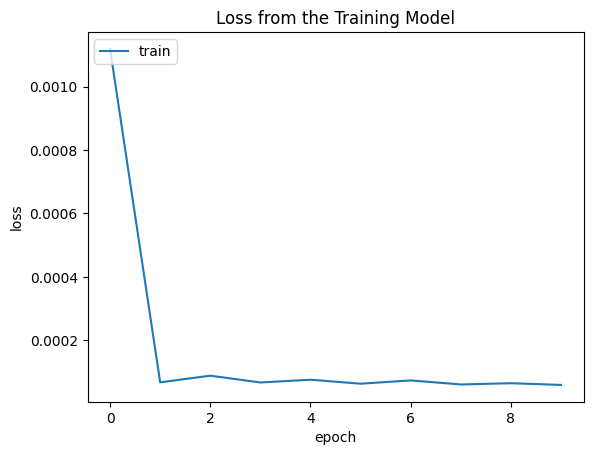

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
# 使用訓練好的模型對訓練集的數據 X_train 進行預測
pred_price_train = model_1_open.predict(X_train)

# 將使用訓練過的 LSTM 模型來預測訓練集中每個數據點的開盤價

210/210 [==============================] - 3s 8ms/step


In [ ]:
# 重新整形目標數據 y_train，將其轉換成二維數組，每個數據點為一個獨立的行
y_train = y_train.reshape(len(y_train), 1)

In [ ]:
y_2_train=y_train-pred_price_train

# y_2_train 表示了模型預測與實際值之間的誤差。

In [ ]:
# 使用 Ridge 迴歸模型來進一步調整和改善預測結

model_2_open = Ridge()

# 將訓練集數據 X_train 重塑為二維數組
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# 使用 y_2_train（即第一階段的預測誤差）訓練 Ridge 模型
model_2_open.fit(X_train, y_2_train)

# 使用訓練好的 Ridge 模型對訓練集進行預測
y_2_pred = model_2_open.predict(X_train)

# 將 Ridge 模型的預測結果加到原來的 LSTM 預測結果上，以改善總體預測準確性
pred_price_train += y_2_pred

# 將原始的 LSTM 預測結果與實際值的差異（誤差）作為目標值來訓練 Ridge 模型。然後，用該模型預測這些誤差並將預測的誤差加回原來的 LSTM 預測結果中，以期達到更精確的總體預測效果

In [ ]:
y_3_train=y_train-pred_price_train

In [ ]:
model_3_open=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_3_open.fit(X_train,y_3_train)
y_3_pred=model_3_open.predict(X_train)
pred_price_train+=y_3_pred

# 使用多階段的 Ridge 模型來糾正前一階段留下的誤差，進而逐步提升預測結果的準確性。

In [ ]:
y_4_train=y_train-pred_price_train

In [ ]:
model_4_open=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_4_open.fit(X_train,y_4_train)
y_4_pred=model_4_open.predict(X_train)
pred_price_train+=y_4_pred

In [ ]:
print(mean_squared_error(pred_price_train,y_train))

2.8459431874826343e-05


In [ ]:
# 將驗證集數據 X_valid 重塑為三維數組，以適應 LSTM 模型的輸入需求
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

# 使用訓練好的 LSTM 模型對驗證集進行預測
price_prediction = model_1_open.predict(X_valid)

# 將 LSTM 模型的預測結果反歸一化，以獲得實際的股票價格預測
price_prediction_valid = sc_valid.inverse_transform(price_prediction)

# 將 X_valid 重新整形回二維數組，以適應 Ridge 模型的輸入需求
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1]))

# 使用三個 Ridge 模型進行驗證集的預測
y_2_valid = model_2_open.predict(X_valid)
y_3_valid = model_3_open.predict(X_valid)
y_4_valid = model_4_open.predict(X_valid)

# 將三個 Ridge 模型的預測結果總和加到 LSTM 模型的預測結果上
price_prediction_valid += (y_2_valid + y_3_valid + y_4_valid)

# 創建一個元素全為零的數組，長度為 WINDOW_SIZE_SEARCH
zeros = np.zeros([WINDOW_SIZE_SEARCH])

# 將零數組與調整後的預測結果連接起來，以對齊時間序列
price_prediction = np.concatenate((zeros, price_prediction_valid), axis=None)

22/22 [==============================] - 0s 7ms/step


In [ ]:
price_error = mean_squared_error(valid_set, price_prediction)
print("Price error on the validation set : ", price_error)

Price error on the validation set :  6.999610507566676


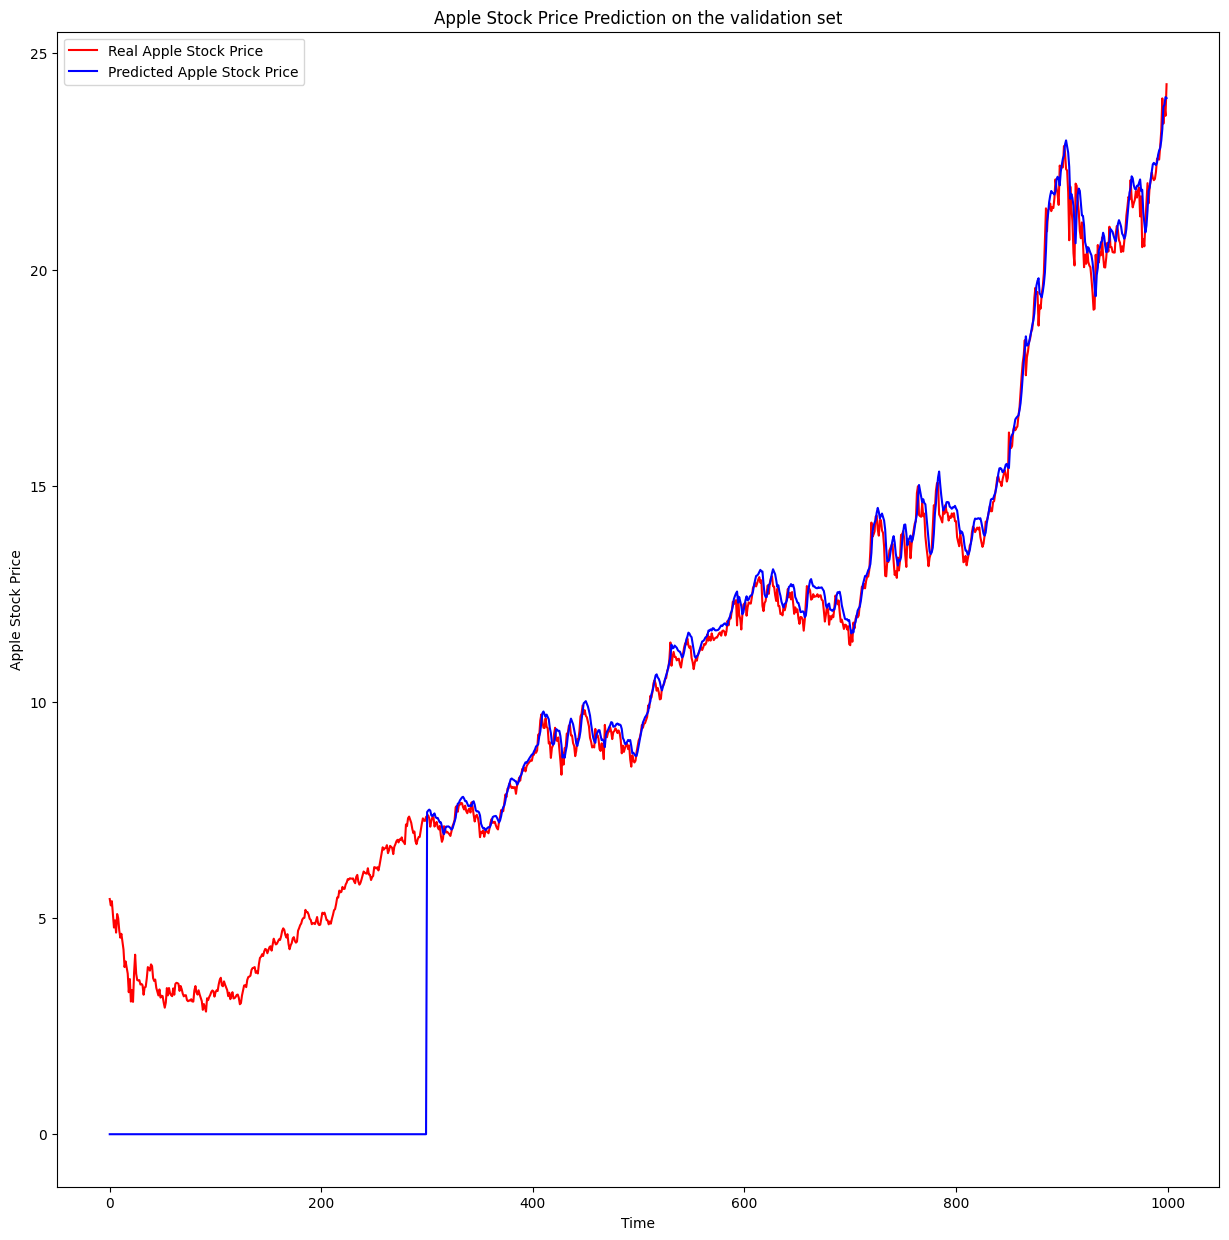

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(valid_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the validation set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
# @title 測試資料集
X_test, y_test = generate_data(test_set_scaled, WINDOW_SIZE_SEARCH)

# 將測試集特徵數據重塑為三維數組，以適應 LSTM 模型的輸入格式
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 使用 LSTM 模型對測試集進行預測
price_prediction_test = model_1_open.predict(X_test)

# 重新整形測試集特徵數據為二維數組，以適應 Ridge 模型的輸入需求
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# 計算 LSTM 模型預測與實際目標值的均方誤差
price_error = mean_squared_error(y_test, price_prediction_test)
print("Price error on the test set : ", price_error)

# 使用三個 Ridge 模型進行測試集的預測
y_2_test = model_2_open.predict(X_test)
y_3_test = model_3_open.predict(X_test)
y_4_test = model_4_open.predict(X_test)

# 將三個 Ridge 模型的預測結果總和加到 LSTM 模型的預測結果上
price_prediction_test += (y_2_test + y_3_test + y_4_test)

# 反歸一化最終的預測結果，以獲得實際的股票價格預測
price_prediction_test = sc_test.inverse_transform(price_prediction_test)


66/66 [==============================] - 1s 8ms/step
Price error on the test set :  0.0001324129551729914


In [ ]:
price_error = mean_squared_error(test_set[WINDOW_SIZE_SEARCH:], price_prediction_test)
print("Price error on the test set : ", price_error)

Price error on the test set :  2.6379694540354186


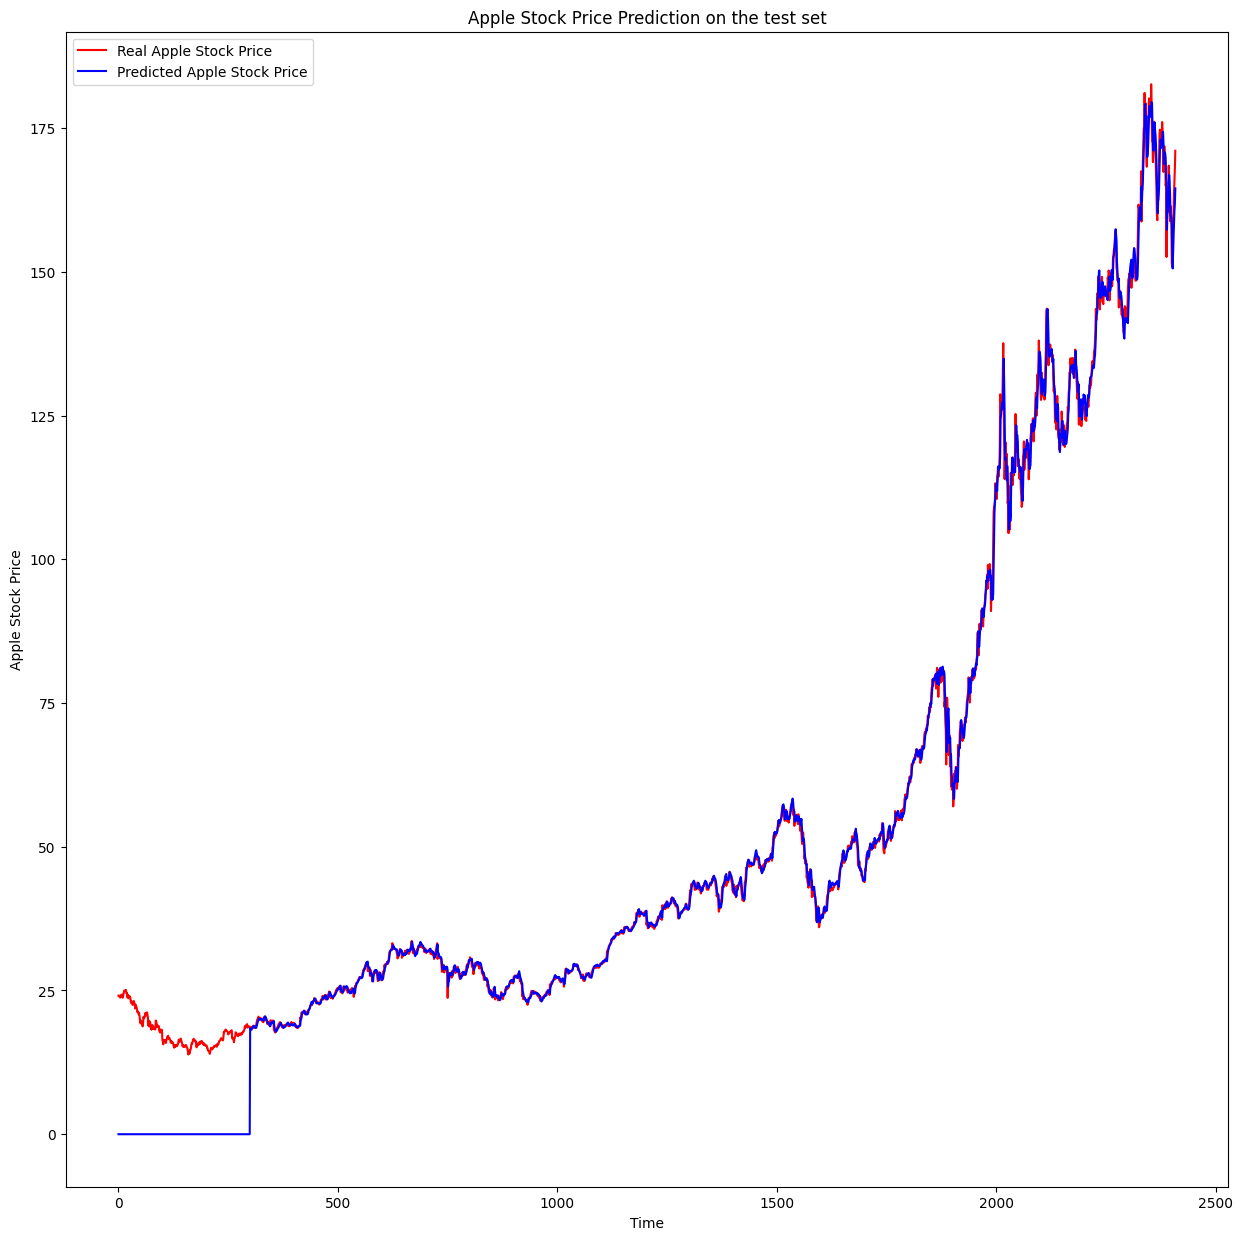

In [ ]:
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction_test = np.concatenate((zeros, price_prediction_test), axis=None)
plt.figure(figsize=(15,15))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction_test, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the test set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
# @title 訓練資料集
df_apple = pd.read_csv("/content/drive/My Drive/Kaggle/AAPL.csv.xls")
df_apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [ ]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'], format="%Y-%m-%d")

In [ ]:
close_price=df_apple.loc[:,'Close'].to_numpy()

In [ ]:
close_price = close_price.reshape(-1, 1)
train_set = close_price[:7000]
valid_set = close_price[7000:8000]
test_set = close_price[8000:]

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_valid = MinMaxScaler(feature_range=(0, 1))
sc_test = MinMaxScaler(feature_range=(0, 1))

train_set_scaled = sc.fit_transform(train_set)
valid_set_scaled = sc_valid.fit_transform(valid_set)
test_set_scaled = sc_test.fit_transform(test_set)

In [ ]:
def generate_data(data, window_size_input = 300):
    X = []
    y = []
    for i in range(window_size_input, len(data)):
        # Get the data
        X_data = data[i - window_size_input : i, 0]
        y_data = data[i, 0]
        X.append(X_data)
        y.append(y_data)
    return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE_SEARCH = 300

X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE_SEARCH)
X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE_SEARCH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [ ]:
model_1_close = Sequential()

model_1_close.add(LSTM(256, return_sequences=False, input_shape= (X_train.shape[1], 1)))
model_1_close.add(Dense(128))
model_1_close.add(Dense(64))
model_1_close.add(Dense(1))

model_1_close.compile(optimizer = 'adam', loss = 'mean_squared_error',)

In [ ]:
hist = model_1_close.fit(X_train, y_train, epochs = 10, batch_size = 64, verbose = 2)

Epoch 1/10
105/105 - 5s - loss: 6.1974e-04 - 5s/epoch - 48ms/step
Epoch 2/10
105/105 - 2s - loss: 7.4241e-05 - 2s/epoch - 20ms/step
Epoch 3/10
105/105 - 2s - loss: 8.7719e-05 - 2s/epoch - 20ms/step
Epoch 4/10
105/105 - 2s - loss: 8.3556e-05 - 2s/epoch - 20ms/step
Epoch 5/10
105/105 - 2s - loss: 7.0304e-05 - 2s/epoch - 21ms/step
Epoch 6/10
105/105 - 2s - loss: 7.7705e-05 - 2s/epoch - 21ms/step
Epoch 7/10
105/105 - 2s - loss: 1.0792e-04 - 2s/epoch - 20ms/step
Epoch 8/10
105/105 - 2s - loss: 9.2795e-05 - 2s/epoch - 20ms/step
Epoch 9/10
105/105 - 2s - loss: 6.4581e-05 - 2s/epoch - 20ms/step
Epoch 10/10
105/105 - 2s - loss: 6.2395e-05 - 2s/epoch - 20ms/step


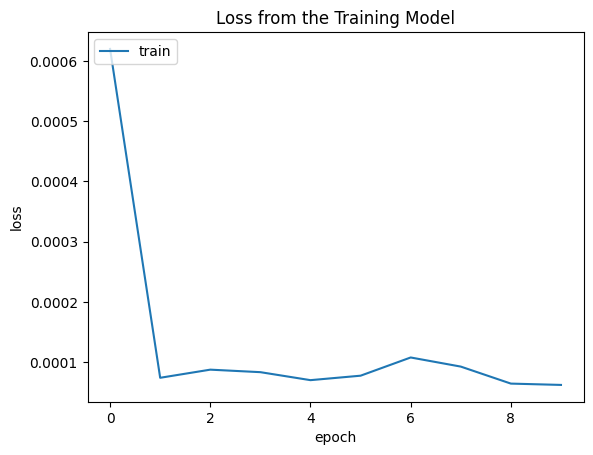

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
pred_price_train=model_1_open.predict(X_train)

210/210 [==============================] - 2s 7ms/step


In [ ]:
y_train=y_train.reshape(len(y_train),1)

In [ ]:
y_2_train=y_train-pred_price_train

In [ ]:
model_2_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_2_close.fit(X_train,y_2_train)
y_2_pred=model_2_close.predict(X_train)
pred_price_train+=y_2_pred

In [ ]:
y_3_train=y_train-pred_price_train

In [ ]:
model_3_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_3_close.fit(X_train,y_3_train)
y_3_pred=model_3_close.predict(X_train)
pred_price_train+=y_3_pred

In [ ]:
y_4_train=y_train-pred_price_train

In [ ]:
model_4_close=Ridge()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_4_close.fit(X_train,y_4_train)
y_4_pred=model_4_close.predict(X_train)
pred_price_train+=y_4_pred

In [ ]:
print(mean_squared_error(pred_price_train,y_train))

2.6905613965302424e-05


In [ ]:
# @title 驗證資料集
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
price_prediction = model_1_close.predict(X_valid)
price_prediction_valid = sc_valid.inverse_transform(price_prediction)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1]))
y_2_valid=model_2_close.predict(X_valid)
y_3_valid=model_3_close.predict(X_valid)
y_4_valid=model_4_close.predict(X_valid)
price_prediction_valid+=(y_2_valid+y_3_valid+y_4_valid)
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction = np.concatenate((zeros, price_prediction_valid), axis=None)

22/22 [==============================] - 1s 12ms/step


In [ ]:
price_error = mean_squared_error(valid_set, price_prediction)
print("Price error on the validation set : ", price_error)

Price error on the validation set :  6.981585631779831


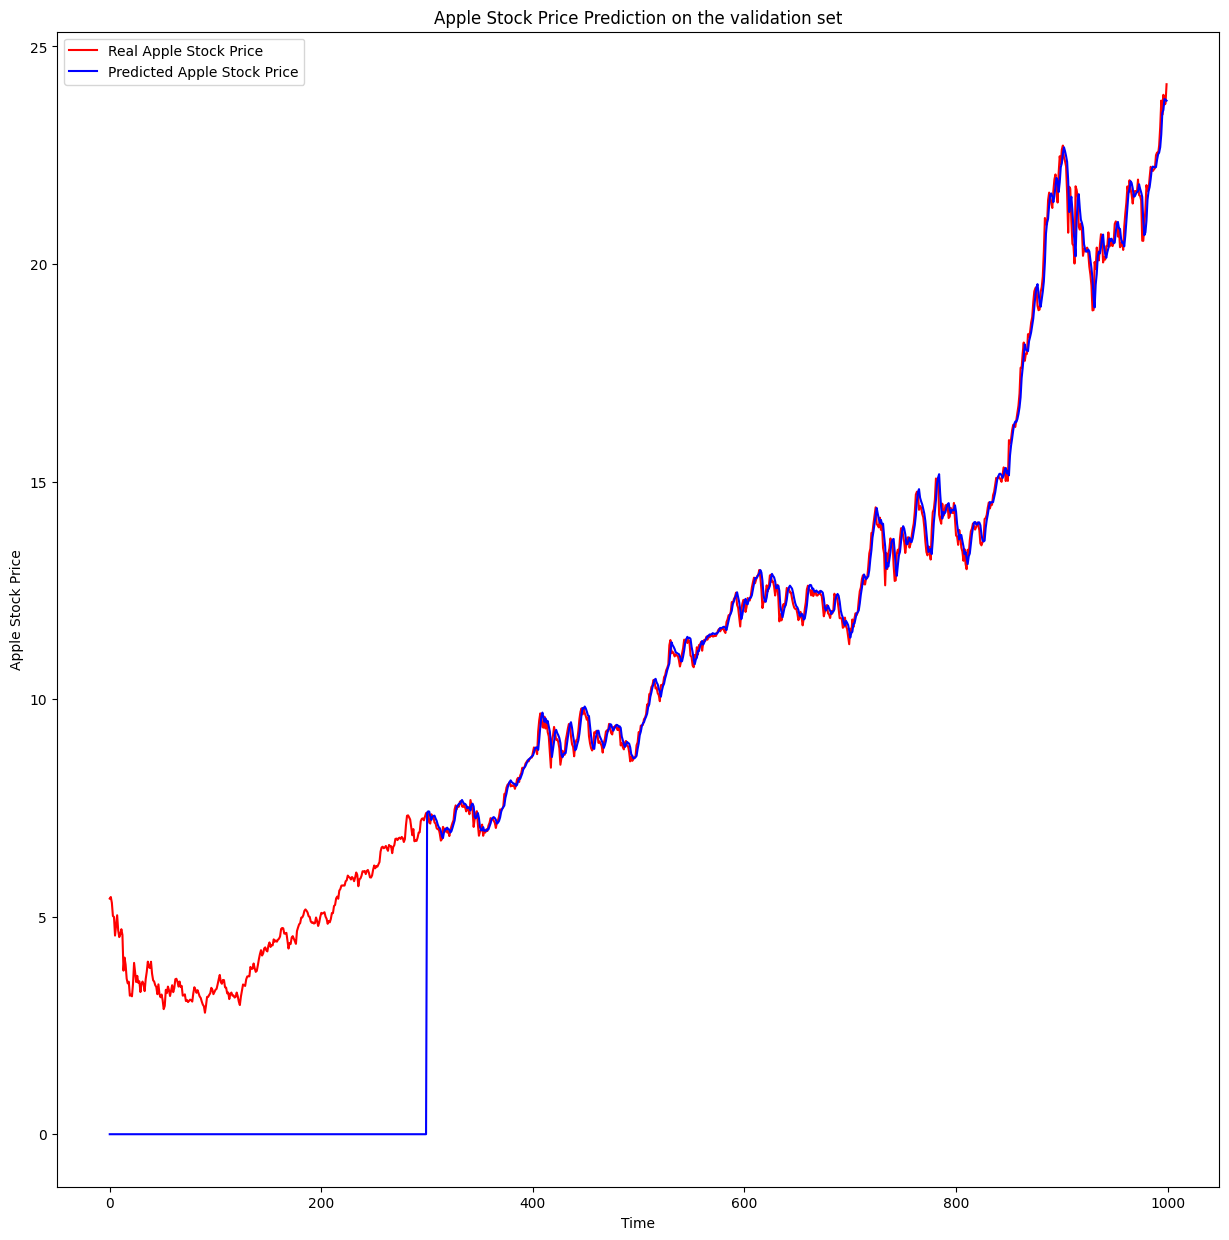

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(valid_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the validation set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
# @title 測試資料集
X_test, y_test = generate_data(test_set_scaled, WINDOW_SIZE_SEARCH)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
price_prediction_test = model_1_close.predict(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
price_error = mean_squared_error(y_test, price_prediction_test)
print("Price error on the test set : ", price_error)
y_2_test=model_2_close.predict(X_test)
y_3_test=model_3_close.predict(X_test)
y_4_test=model_4_close.predict(X_test)
price_prediction_test+=(y_2_test+y_3_test+y_4_test)
price_prediction_test = sc_test.inverse_transform(price_prediction_test)

66/66 [==============================] - 0s 7ms/step
Price error on the test set :  8.20283287038157e-05


In [ ]:
price_error = mean_squared_error(test_set[WINDOW_SIZE_SEARCH:], price_prediction_test)
print("Price error on the test set : ", price_error)

Price error on the test set :  3.1346062733106153


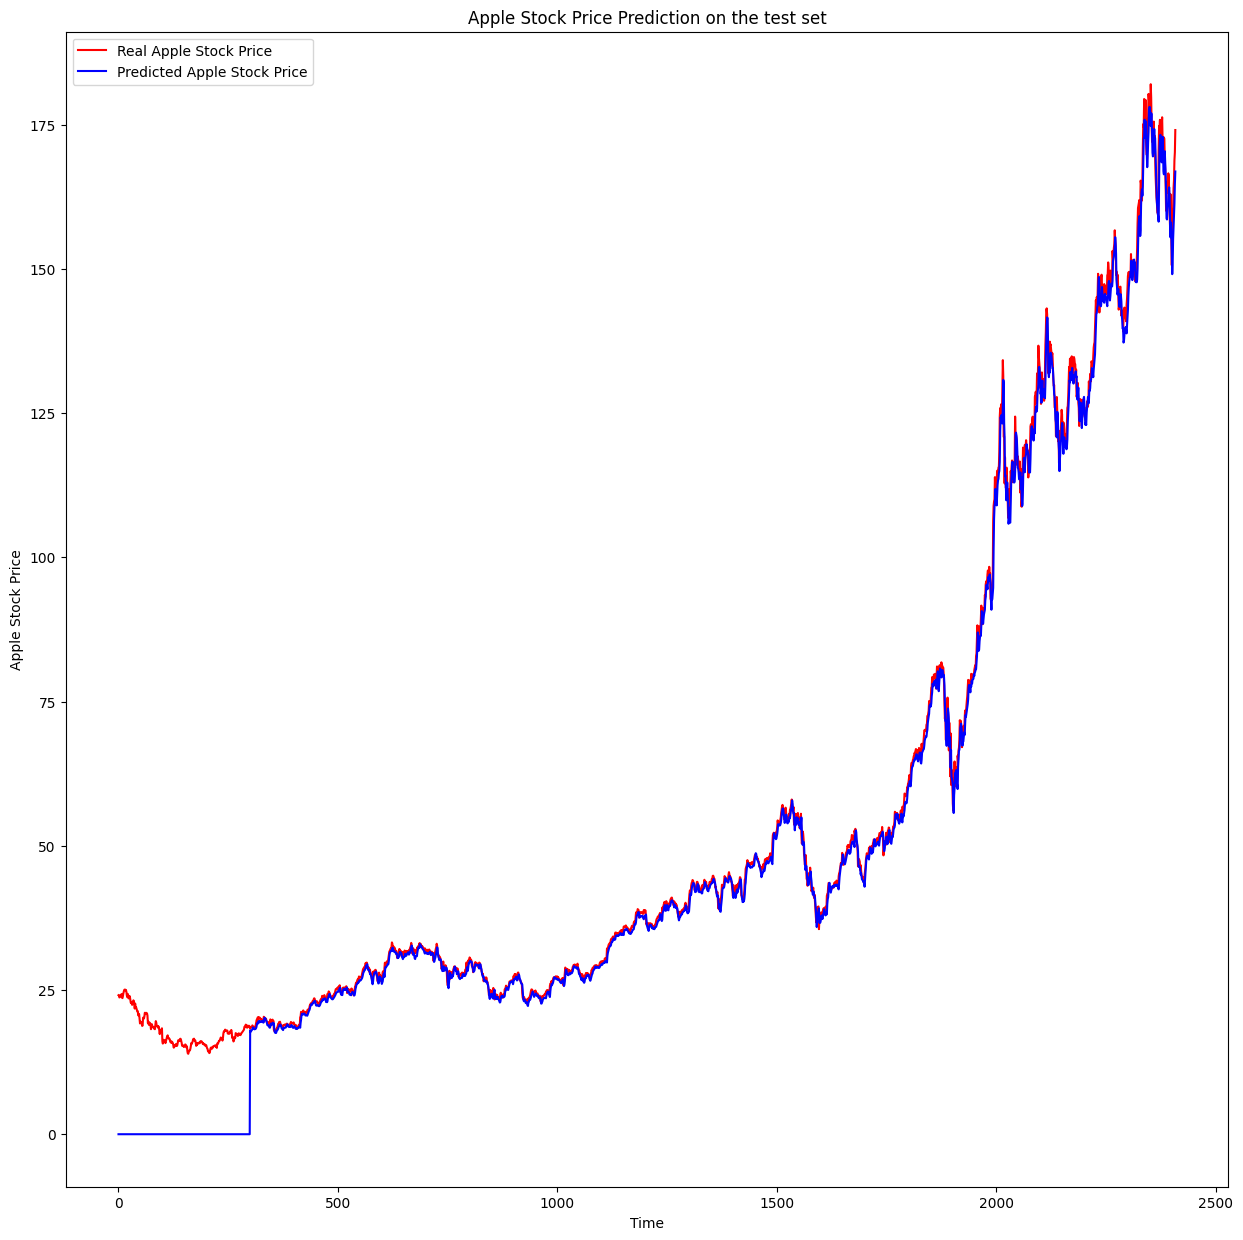

In [ ]:
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction_test = np.concatenate((zeros, price_prediction_test), axis=None)
plt.figure(figsize=(15,15))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction_test, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the test set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()